In [1]:
import os, re, glob, json
import numpy as np
import pandas as pd

from keras.applications.mobilenet import MobileNet
from sklearn.model_selection import train_test_split
from ohia.metrics import top_1_accuracy, top_3_accuracy, top_5_accuracy
from ohia.encoders import FastLabelEncoder
from ohia.utils import PlantNetGenerator

Using TensorFlow backend.


In [2]:
SEED = 0
ALPHA = 1.00
BATCH_SIZE = 64
MODEL_NAME = 'mobilenetv1-1.00'
FILE_PATH = 'data'
IMAGE_DIR = 'preprocessed_images'

In [3]:
# get list of images and labels
file_list = glob.glob(f'{FILE_PATH}\\{IMAGE_DIR}\\**\\*.jpg', recursive=True)
full_label_list = [re.split('\\\\', f)[-2] for f in file_list]

In [4]:
# encode label names with ids
fle = FastLabelEncoder()
label_ids = fle.fit_transform(full_label_list)

In [5]:
# save id2label map
id2label = {int(fle.transform([label])):label for label in np.unique(full_label_list)}

In [6]:
# split data
train_files, valid_files, train_ids, valid_ids \
    = train_test_split(file_list, label_ids, test_size=0.1, random_state=SEED)

In [89]:
len(train_ids)

10593

In [90]:
len(valid_ids)

1178

In [7]:
# create generators
n_classes = len(np.unique(full_label_list))
valid_generator = PlantNetGenerator(valid_files, valid_ids, n_classes, BATCH_SIZE, augment=False, shuffle=False)

In [8]:
# load pretrained ImageNet model
base_model = MobileNet(
    input_shape=(224,224,3),
    weights='imagenet',
    include_top=False
)

# set freeze all layers
for layer in base_model.layers:
    layer.trainable = False
    
# map ImageNet features to plants
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
outputs = layers.Dense(n_classes, activation='softmax')(x)
    

In [9]:
# compile the model
model = Model(inputs=base_model.input, outputs=outputs)
model.compile(
    optimizer=Adam(lr=0.0001),
    loss='categorical_crossentropy',
    metrics=[top_1_accuracy, top_3_accuracy, top_5_accuracy]
)

In [10]:
# load best model
best_weights = glob.glob(f'{FILE_PATH}\\{MODEL_NAME}**')
best_weights = np.sort(best_weights)[0]
model.load_weights(best_weights)


In [85]:
train_pred = model.predict_generator(train_generator)
prediction = model.predict_generator(valid_generator)
prediction.shape

(1152, 23)

In [12]:
pred_ids_sort = np.argsort(prediction, axis=1)
pred_ids_sort.shape

(1152, 23)

In [13]:
print(pred_ids_sort)

[[ 5 12 14 ...  9 22 15]
 [ 6 12 16 ... 22 21 13]
 [16  6 20 ...  3  7  8]
 ...
 [16 10  1 ... 13 17  9]
 [ 1  6  4 ... 22 21 13]
 [12  6 16 ...  7 13 21]]


In [15]:
pred_ids_sort_label  = np.array([ [id2label[col] for col in row ] for row in np.array(pred_ids_sort)])
pred_ids_sort_label.shape

(1152, 23)

In [16]:
print(pred_ids_sort_label)

[['Bougainvillea' 'Heliconia' 'Officinale' ... 'Cyperus' 'Senecio'
  'Panicum']
 ['Cocos' 'Heliconia' 'Pennisetum' ... 'Senecio' 'Rubus' 'Hibiscus']
 ['Pennisetum' 'Cocos' 'Pseudognaphalium' ... 'Anthurium' 'Cordia'
  'Cordyline']
 ...
 ['Pennisetum' 'Delairea' 'Aleurites' ... 'Hibiscus' 'Plumeria' 'Cyperus']
 ['Aleurites' 'Cocos' 'Artocarpus' ... 'Senecio' 'Rubus' 'Hibiscus']
 ['Heliconia' 'Cocos' 'Pennisetum' ... 'Cordia' 'Hibiscus' 'Rubus']]


In [17]:
valid_labels = [id2label[i] for i in valid_ids]
valid_labels = valid_labels[:1152]

In [18]:
adjusted_valid_labels = valid_labels[:1152]
accuracy_sort         = []
i = 0
for v in adjusted_valid_labels:
    accuracy_sort.append(pred_ids_sort_label[i] == v)
    i = i + 1

accuracy_sort = np.array(accuracy_sort)

In [19]:
accuracy_sort[:,-1].mean()

0.6605902777777778

## Top 1, Top 3, Top 5 Accuracy

In [94]:
top_1 = accuracy_sort[:,-1:].sum(axis=1)>0
top_3 = accuracy_sort[:,-3:].sum(axis=1)>0
top_5 = accuracy_sort[:,-5:].sum(axis=1)>0

comb_all = pd.DataFrame({
    "labels": valid_labels,
    "top_1": top_1,
    "top_3": top_3,
    "top_5": top_5
})
comb_all = comb_all.groupby(["labels"])
comb_all = comb_all.agg(['mean'])
comb_all.head(100)

,top_1,top_3,top_5
,mean,mean,mean
labels,,,
Abutilon,0.178571,0.750000,0.785714
Aleurites,0.555556,0.703704,0.814815
Ananas,0.809524,0.904762,0.936508
Anthurium,0.581395,0.848837,0.918605
Artocarpus,0.750000,0.888889,0.944444
Bougainvillea,0.623377,0.870130,0.909091
Cocos,0.400000,0.720000,0.880000
Cordia,0.724138,0.896552,0.965517


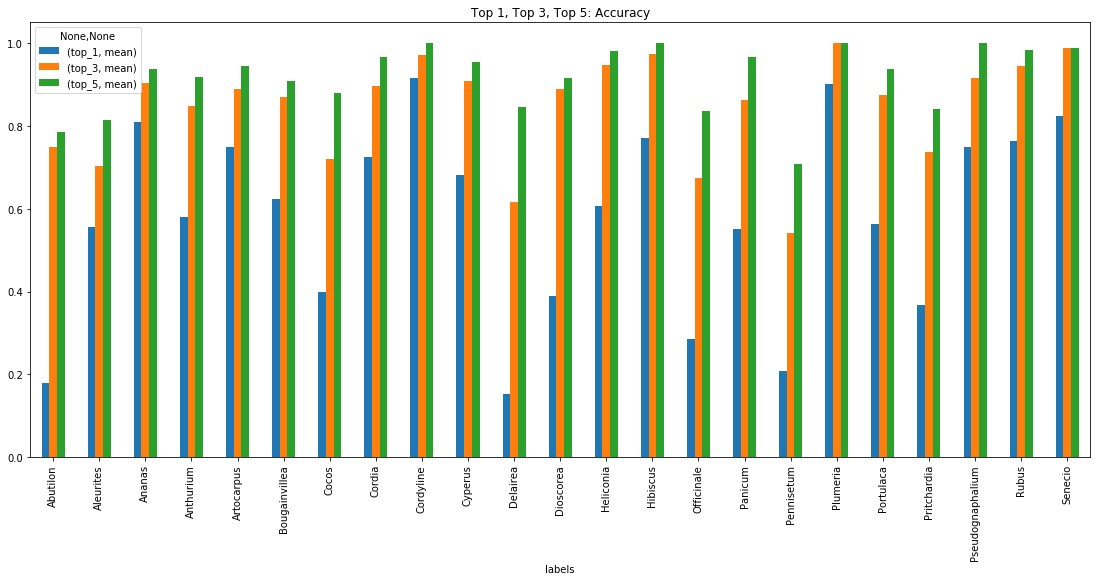

In [95]:
import matplotlib.pyplot as plt
comb_all.plot.bar(figsize=(19,8), title="Top 1, Top 3, Top 5: Accuracy")

## Accuracy Vs. Training Size

In [149]:
# train_ids
train_labels   = [id2label[i] for i in train_ids]
a              = np.array(train_labels)
unique, counts = np.unique(a, return_counts=True)

comb_top_1 = pd.DataFrame({
    "labels": valid_labels,
    "top_1": top_1,
})
comb_top_1 = comb_top_1.groupby(["labels"])
comb_top_1 = comb_top_1.agg({ 'top_1':  ['mean']})
comb_top_1.columns = ['accuracy']

comb_train = pd.DataFrame({
    "labels": unique,
    "train_count": counts
})
comb_train = comb_train.set_index('labels')

# comb_train.head(100)
# print(comb_top_1.head(10))
# print(comb_train.head(10))
comb_train = pd.concat([comb_top_1, comb_train], axis=1, sort=False, join_axes=[comb_top_1.index])

comb_train.head(100)

,accuracy,train_count
labels,,
Abutilon,0.178571,216
Aleurites,0.555556,309
Ananas,0.809524,660
Anthurium,0.581395,804
Artocarpus,0.750000,309
Bougainvillea,0.623377,663
Cocos,0.400000,332
Cordia,0.724138,295
Cordyline,0.916667,329


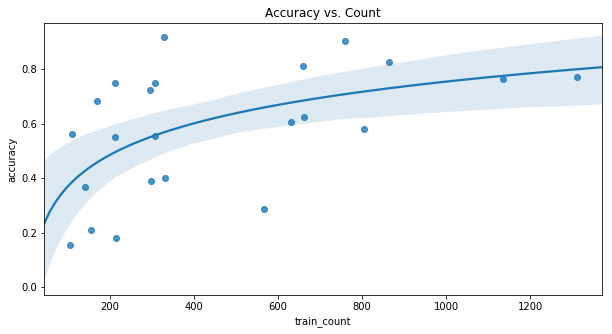

In [179]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10,5), )

ax.set_title("Accuracy vs. Count")

sns.regplot(comb_train['train_count'], comb_train['accuracy'], logx = True,ax=ax)

plt.show()